In [4]:
import torch
import torch.distributions as dist
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt
from flows import Planar
import numpy as np

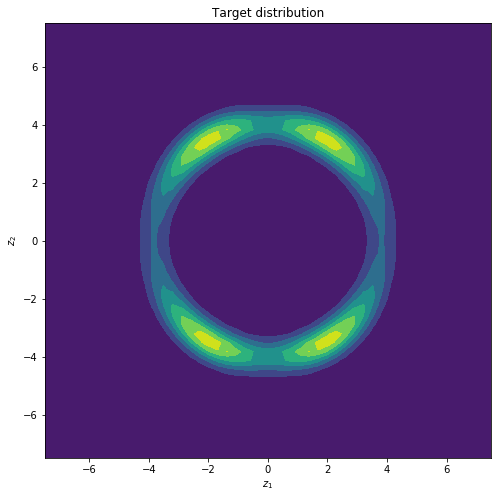

In [5]:
def target_density(z):
    z1, z2 = z[..., 0], z[..., 1]
    norm = (z1**2 + z2**2)**0.5
    exp1 = torch.exp(-0.2 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.2 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

x1 = np.linspace(-7.5, 7.5)
x2 = np.linspace(-7.5, 7.5)
x1_s, x2_s = np.meshgrid(x1, x2)
x_field = np.concatenate([x1_s[..., None], x2_s[..., None]], axis=-1)
x_field = torch.tensor(x_field, dtype=torch.float)

plt.figure(figsize=(8, 8))
plt.title("Target distribution")
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.contourf(x1_s, x2_s, target_density(x_field))
plt.show()

In [6]:
def det_loss(mu, log_var, z_0, z_k, ldj, beta):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    batch_size = z_0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    # P(x|z)
    nll = -torch.log(target_density(z_k) + 1e-7).sum() * beta
    return (log_qzk + nll) / batch_size

In [7]:
def train_flow(flow, shape, epochs=1000):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)

    for i in range(epochs):
        z0, zk, ldj, mu, log_var = flow(shape=shape)
        loss = det_loss(mu=mu,
                        log_var=log_var,
                        z_0=z0,
                        z_k=zk,
                        ldj=ldj,
                        beta=1)
        loss.backward()
        optim.step()
        optim.zero_grad()
        if i % 250 == 0:
            print(loss.item())


In [8]:
class Flow(nn.Module):
    def __init__(self, dim=2, n_flows=10):
        super().__init__()
        self.flow = nn.Sequential(*[
            Planar(dim) for _ in range(n_flows)
        ])
        self.mu = nn.Parameter(torch.randn(dim, ).normal_(0, 0.01))
        self.log_var = nn.Parameter(torch.randn(dim, ).normal_(1, 0.01))

    def forward(self, shape):
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn(shape)  # unit gaussian
        z0 = self.mu + eps * std

        zk, ldj = self.flow(z0)
        return z0, zk, ldj, self.mu, self.log_var

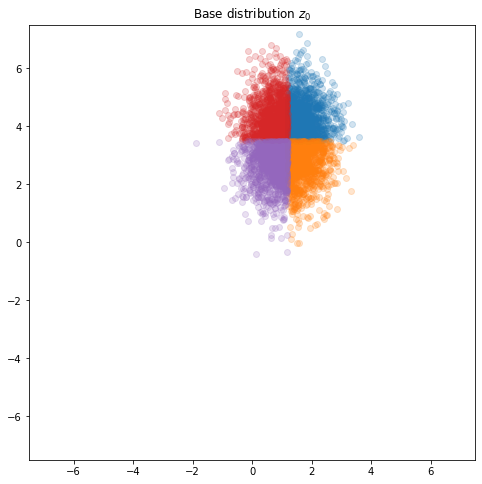

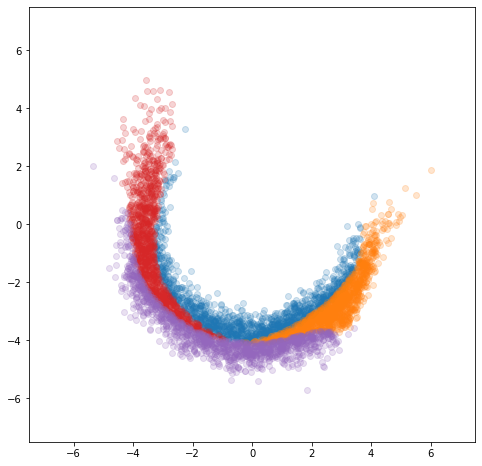

In [31]:
def show_samples(s0, sk, mu, title):
    
    alpha = 0.2
    
    mask_1 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] > mu[1])
    mask_2 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] < mu[1])
    mask_3 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] > mu[1])
    mask_4 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] < mu[1])
    
    for s, title in zip([s0, sk], ['Base distribution $z_0$', title]):
        plt.figure(figsize=(8, 8))
        plt.title(title)
        plt.scatter(s[:, 0][mask_1], s[:, 1][mask_1], color='C0', alpha=alpha)
        plt.scatter(s[:, 0][mask_2], s[:, 1][mask_2], color='C1', alpha=alpha)
        plt.scatter(s[:, 0][mask_3], s[:, 1][mask_3], color='C3', alpha=alpha)
        plt.scatter(s[:, 0][mask_4], s[:, 1][mask_4], color='C4', alpha=alpha)

        plt.xlim(-7.5, 7.5)
        plt.ylim(-7.5, 7.5)
        plt.show()

show_samples(z0.data, zk.data, mu, '')

7.278123378753662
-0.06517407298088074
-1.1498440504074097
-1.2009861469268799
-1.1681851148605347
-1.2341387271881104
-1.2045807838439941
-1.2474123239517212
-1.4144967794418335
-1.5798981189727783
-1.6710907220840454
-1.650998830795288
-1.6613128185272217
-1.7138704061508179
-1.7263134717941284
-1.6816388368606567
-1.6935312747955322
-1.7197072505950928
-1.7608659267425537
-1.6937004327774048


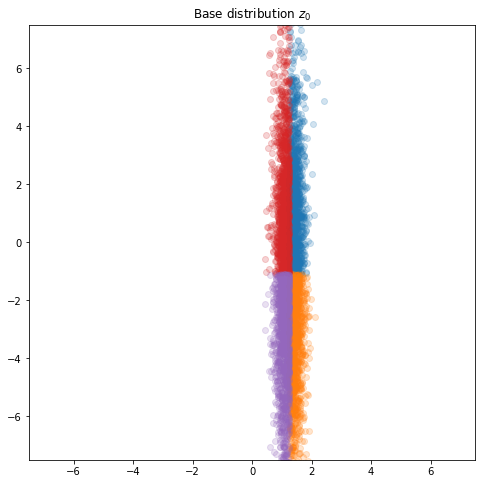

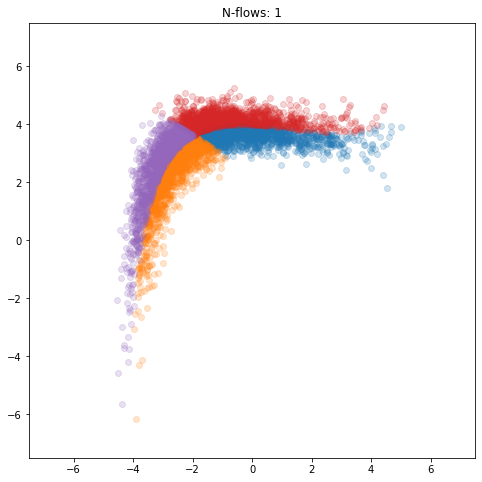

7.100916862487793
-1.6185798645019531
-1.8309497833251953
-2.0495121479034424
-2.0638716220855713
-2.0980236530303955
-2.111708164215088
-2.1428263187408447
-2.1643121242523193
-2.1826276779174805
-2.189134120941162
-2.2182157039642334
-2.232978105545044
-2.196544647216797
-2.259760856628418
-2.280242681503296
-2.2523412704467773
-2.302569627761841
-2.290229558944702
-2.3094608783721924


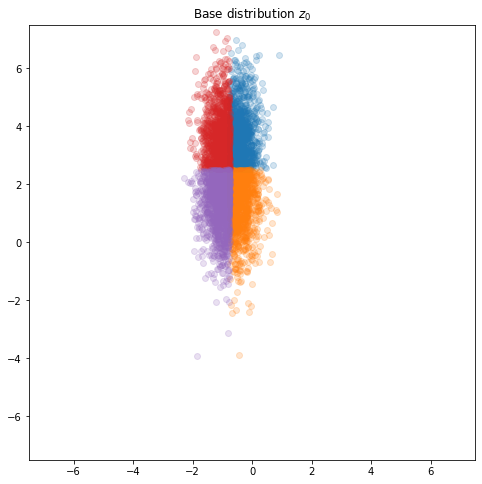

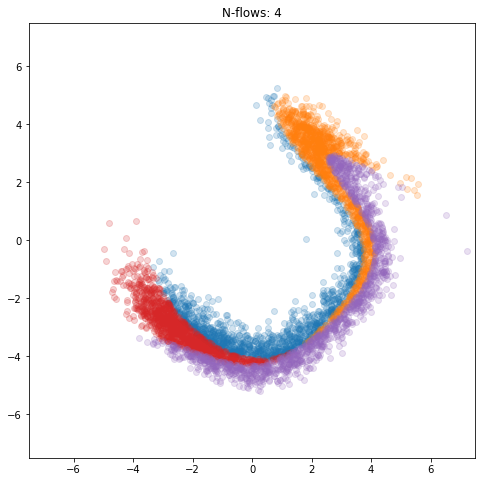

7.049882411956787
-1.682941198348999
-2.020503044128418
-2.090329170227051
-2.1708309650421143
-2.2287774085998535
-2.4648280143737793
-2.555990219116211
-2.5283095836639404
-2.569547653198242
-2.5590107440948486
-2.577707529067993
-2.586432695388794
-2.595658540725708
-2.586582660675049
-2.6460869312286377
-2.6358773708343506
-2.6345860958099365
-2.6267106533050537
-2.644540786743164


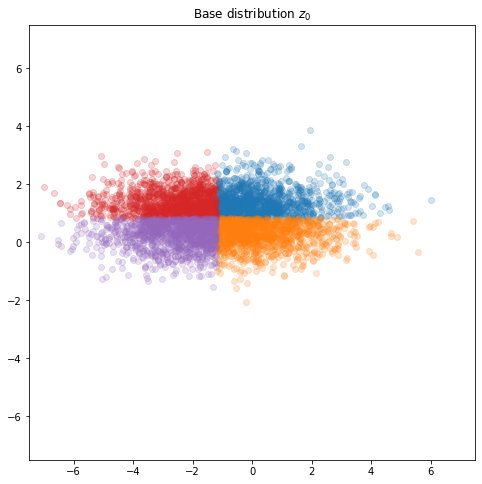

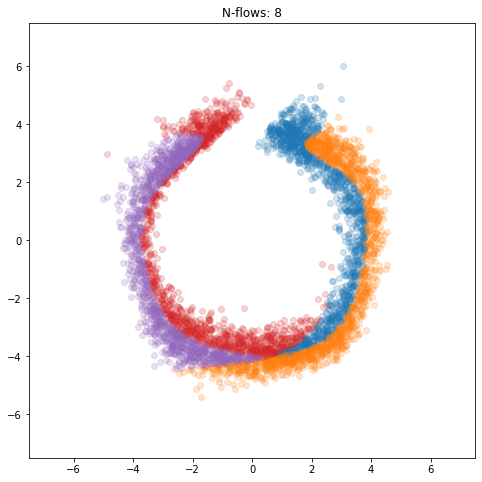

7.500013828277588
-1.5257598161697388
-1.9692480564117432
-2.0864098072052
-2.1868417263031006
-2.4774999618530273
-2.549960136413574
-2.693189859390259
-2.6896300315856934
-2.6878716945648193
-2.725862503051758
-2.715972423553467
-2.7163946628570557
-2.737302780151367
-2.6942050457000732
-2.735264539718628
-2.7352728843688965
-2.7217235565185547
-2.73087477684021
-2.7370047569274902


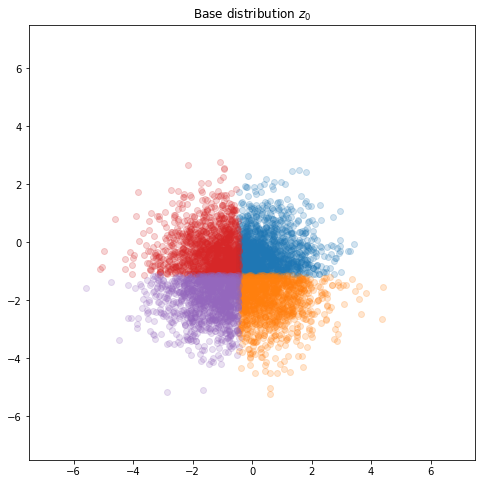

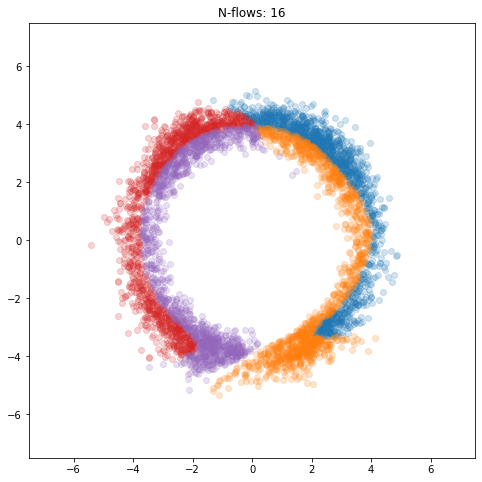

In [33]:
for n_flows in [1, 4, 8, 16]:
    flow = Flow(dim=2, n_flows=n_flows)
    shape = (1000, 2)
    train_flow(flow, shape, epochs=5000)
    z0, zk, ldj, mu, log_var = flow((5000, 2))
    show_samples(z0.data, zk.data, mu, f"N-flows: {n_flows}")
